## Calculate wet bulb temperature from temperature and specific humidity

In [1]:
import xarray as xr
from dask.diagnostics import ProgressBar
from wrf import wetbulb
from netCDF4 import Dataset
from wrf import getvar

In [2]:
# Point to model data
rootdir = '/local/ss23/GFDL_LEs/ATM/RCP85/'
suffix = '.rcp85.ens101.1950_2100.nc'
variables = ['sphum_k24','ps','t_ref']
ds = xr.Dataset()
for var in variables:
    print(var)
    ds[var] = xr.open_dataarray(rootdir+var+suffix,chunks={'time':1}).squeeze()
# Calculate the water vapor mixing ratio from specific humidity
ds['qvr'] = ds['sphum_k24']/(1-ds['sphum_k24'])

sphum_k24
ps
t_ref


In [6]:
# Convert pressure to hectopascals
ds['ps'].name = 'prs'
ds['t_ref'].name = 'tmk'

In [4]:
getvar(ds,'twb')

TypeError: iteration over a 0-d array

In [11]:
# Wrap MetPy function into an apply_ufunc calculation to work with dask array
def wrt_wetbulb(pressure, temperature, water_vapor_mixing_ratio):
    return xr.apply_ufunc(wetbulb,
                             pressure, temperature, water_vapor_mixing_ratio, 
                             dask='parallelized',output_dtypes=[water_vapor_mixing_ratio.dtype])

In [12]:
wbt = wrt_wetbulb(ds['ps'],ds['t_ref'],ds['wvmr'])

In [6]:
wbt

<xarray.DataArray (time: 55115, lat: 90, lon: 144)>
dask.array<wetbulb, shape=(55115, 90, 144), dtype=float32, chunksize=(1, 90, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
    pfull    float64 996.1
  * time     (time) object 1950-01-01 12:00:00 ... 2100-12-31 12:00:00

In [ ]:
wbt.sel(time=slice('1981-01-01','1981-12-31')).mean('time').plot()

In [5]:
# Load the wetbulb temperature from CESM for comparison
rootdir = '/local/ss23/CESM2_LE/ATM/RCP85/WBT/'
filename = 'b.e21.BHISTcmip6.f09_g17.LE2-1231.001.clm2.h7.WBT.1980010100-1990010100.nc'
wbt_cesm = xr.open_dataset(rootdir+filename)['WBT']
wbt_cesm

<xarray.DataArray 'WBT' (time: 29200, lat: 192, lon: 288)>
[1614643200 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * time     (time) object 1980-01-01 00:00:00 ... 1989-12-31 21:00:00
Attributes:
    long_name:     2 m Stull Wet Bulb
    units:         C
    cell_methods:  time: mean

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


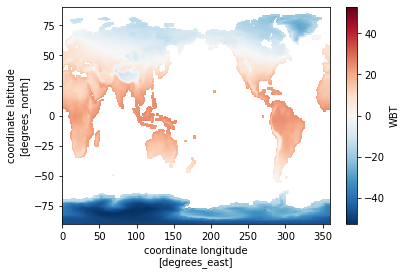

In [6]:
wbt_cesm.sel(time=slice('1980-01-01','1980-12-31')).mean('time').plot()